In [1]:
import sys
import os
import yaml
import pandas as pd
sys.path.append(".")
sys.path.append("../")
sys.path.append("../../")
import numpy as np
import src.utils.io as io   
import torch
import config as config
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import src.utils.preprocess as preprocess
import src.methods.dann as dann
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [3]:
print("Loading source data (Vectronics)...")
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']

min_duration_before_padding = 10.0
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(min_duration_before_padding))
X_src = vectronics_df[Vectronics_feature_cols].values
y_src = vectronics_df['behavior'].values
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)

print("Loading target data (RVC)...")
RVC_df = pd.read_csv(io.get_RVC_preprocessed_path())
X_targets = [RVC_df.loc[RVC_df.firmware_major_version == 2.0, Vectronics_feature_cols].values,
            RVC_df.loc[RVC_df.firmware_major_version == 3.0, Vectronics_feature_cols].values]

# --------------------------
# Preprocess (compute quantiles using all domains)
# --------------------------
pos_idx = [0, 1, 2, 3, 4, 5]  # Indices of features that should be positive
center_idx = [6, 7, 8]  # Indices of features that should be centered at zero
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src], pos_idx=pos_idx, center_idx=center_idx,
    low_q=0.01, high_q=0.99,
)
X_src = preprocess.transform_and_scale(X_src, pos_idx, center_idx, lows, highs)
X_targets = [preprocess.transform_and_scale(Xt, pos_idx, center_idx, lows, highs)
                for Xt in X_targets]

Loading source data (Vectronics)...
Loading target data (RVC)...


/tmp/ipykernel_1480547/3483206054.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


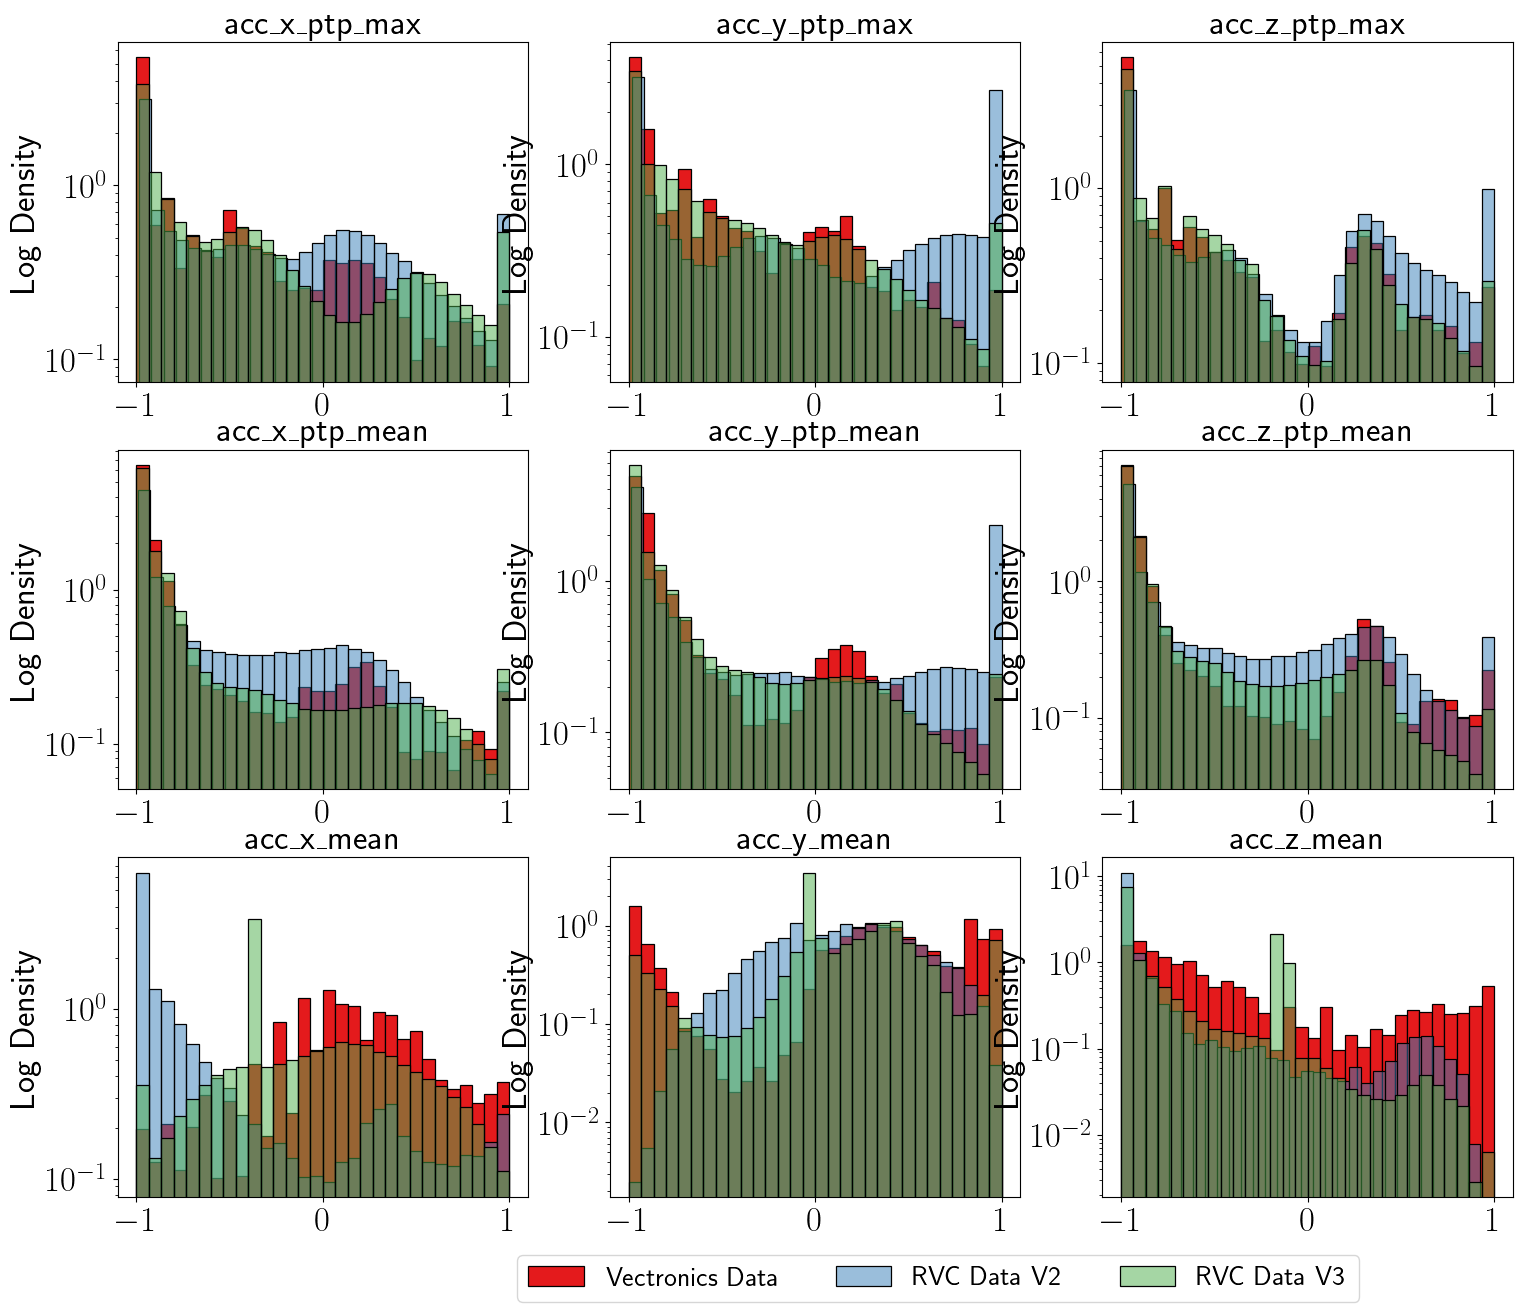

In [4]:
# Plot histograms of features
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(18, 5*(len(Vectronics_feature_cols)//3)))

palette = sns.color_palette("Set1", n_colors=3)
axes = axes.flatten()
for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                X_src[:,i],
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=1.0
            )

        sns.histplot(X_targets[0][:,i],
                kde=False,
                label='RVC Data V2',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.5
            )
        sns.histplot(X_targets[1][:,i],
                kde=False,
                label='RVC Data V3',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[2],
                alpha=0.5
            )
    
        ax.set_title(col)
        ax.set_ylabel('Log Density')
        ax.set_yscale("log")
        ax.set_xlabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(2.0, -2.75), ncol=3)

plt.tight_layout()
plt.show()


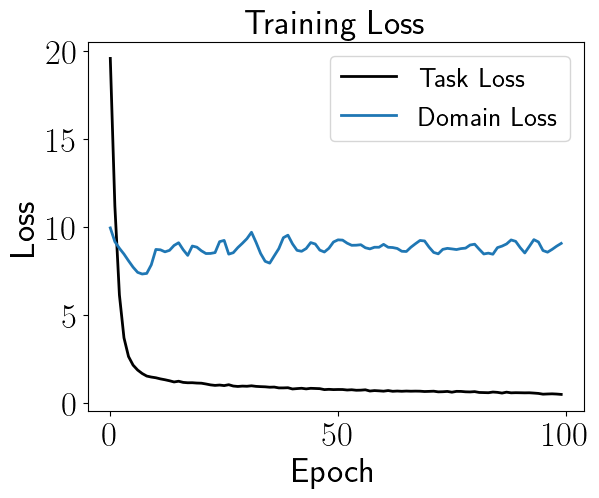

In [5]:
dir = os.path.join(io.get_domain_adaptation_results_dir(), "dann")
loaded = np.load(os.path.join(dir, "training_history.npz"))
task_loss = loaded["task_loss"]
domain_loss = loaded["domain_loss"]
plt.plot(np.arange(len(task_loss)), task_loss, label="Task Loss", linewidth = 2, color='black')
plt.plot(np.arange(len(domain_loss)), domain_loss, label="Domain Loss", linewidth = 2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.show()

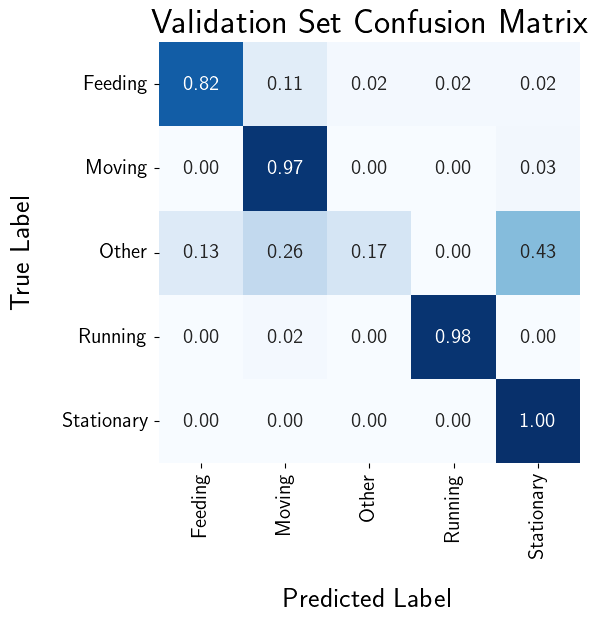

In [6]:
val_preds = np.load(os.path.join(dir, "val_preds.npz"))
val_true = val_preds["val_true"]
val_preds = val_preds["val_preds"]
label_encoder = LabelEncoder()
label_encoder.fit(config.SUMMARY_BEHAVIORS)
class_names = label_encoder.classes_
cm = confusion_matrix(label_encoder.inverse_transform(val_true), label_encoder.inverse_transform(val_preds), labels=class_names, normalize='true')
# Plot
fig, ax = plt.subplots(figsize=(6, 7))

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, square=True, linewidths=0,
            annot_kws={"size": 15}, ax=ax)
ax.set_xlabel("Predicted Label", fontsize=20, labelpad=20)
ax.set_ylabel("True Label", fontsize=20, labelpad=20)
ax.set_xticklabels(class_names, fontsize=15, rotation=90)
ax.set_yticklabels(class_names, fontsize=15, rotation=0)
plt.title("Validation Set Confusion Matrix")
plt.tight_layout()
plt.show()


In [14]:
# Load model
feature_extractor = dann.FeatureExtractor(in_dim=9)
state_dict = torch.load(os.path.join(dir, "feature_extractor.pth"), map_location=device)
feature_extractor.load_state_dict(state_dict)
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

# Convert input
X_src_tensor = torch.tensor(X_src, dtype=torch.float32).to(device)

# Forward pass
X_target_feat = []
with torch.no_grad():
    X_src_feat = feature_extractor(X_src_tensor)
    for Xt in X_targets:
        Xt_tensor = torch.tensor(Xt, dtype=torch.float32).to(device)
        Xt_feat = feature_extractor(Xt_tensor)
        X_target_feat.append(Xt_feat)

X_src_feat = X_src_feat.cpu().numpy()
X_target_feat = [X_t.cpu().numpy() for X_t in X_target_feat]

/tmp/ipykernel_1480547/313352671.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(dir, "feature_extractor.pth"), map_location=device)

/tmp/ipykernel_1480547/3416312130.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


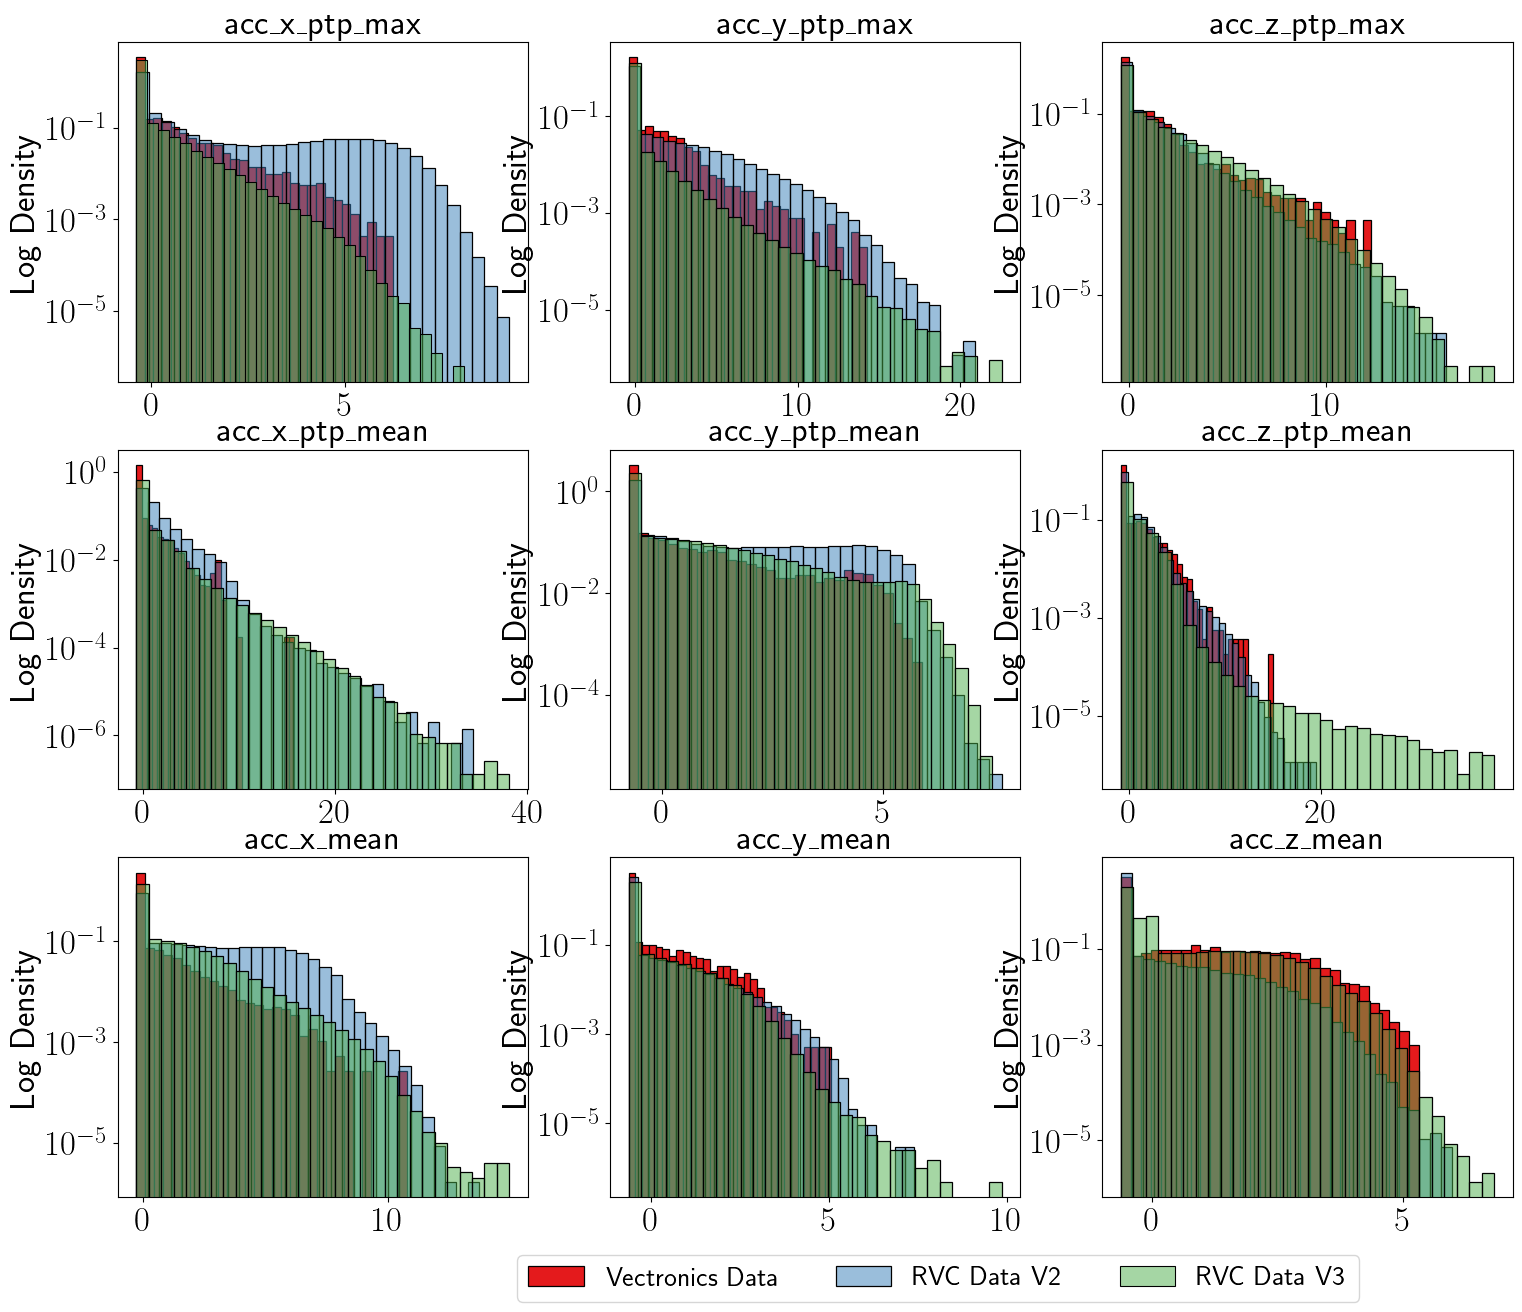

In [8]:
# Plot histograms of features
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(18, 5*(len(Vectronics_feature_cols)//3)))

palette = sns.color_palette("Set1", n_colors=3)
axes = axes.flatten()
for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                X_src_feat[:,i],
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=1.0
            )

        sns.histplot(X_target_feat[0][:,i],
                kde=False,
                label='RVC Data V2',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.5
            )
        sns.histplot(X_target_feat[1][:,i],
                kde=False,
                label='RVC Data V3',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[2],
                alpha=0.5
            )
    
        ax.set_title(col)
        ax.set_ylabel('Log Density')
        ax.set_yscale("log")
        ax.set_xlabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(2.0, -2.75), ncol=3)

plt.tight_layout()
plt.show()


In [17]:
label_classifier = dann.LabelClassifier(in_dim=64, n_classes=5).to(device)
state_dict = torch.load(os.path.join(dir, "label_classifier.pth"), map_location=device)
label_classifier.load_state_dict(state_dict)
label_classifier = label_classifier.to(device)
label_classifier.eval()

# Convert input
X_src_tensor = torch.tensor(X_src, dtype=torch.float32).to(device)

# Forward pass
X_target_feat = []
X_target_logits = []
with torch.no_grad():
    X_src_feat = feature_extractor(X_src_tensor)
    X_src_logits = label_classifier(X_src_feat)
    for Xt in X_targets:
        Xt_tensor = torch.tensor(Xt, dtype=torch.float32).to(device)
        Xt_feat = feature_extractor(Xt_tensor)
        X_target_feat.append(Xt_feat)
        X_target_logits.append(label_classifier(Xt_feat))

/tmp/ipykernel_1480547/3339109272.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(dir, "label_classifier.pth"), map_location=device)

In [26]:
np.unique(np.argmax(X_target_logits[0].cpu().numpy(), axis=1), return_counts=True)[1]

array([173661, 126368,  88589, 134874, 728850])

In [19]:
X_target_logits[0].shape

torch.Size([1252342, 5])